In [1]:
using Distributed
using SharedArrays
addprocs(13);

In [2]:
@everywhere include("inverse_prob.jl")
@everywhere using PyPlot, DSP, JLD2

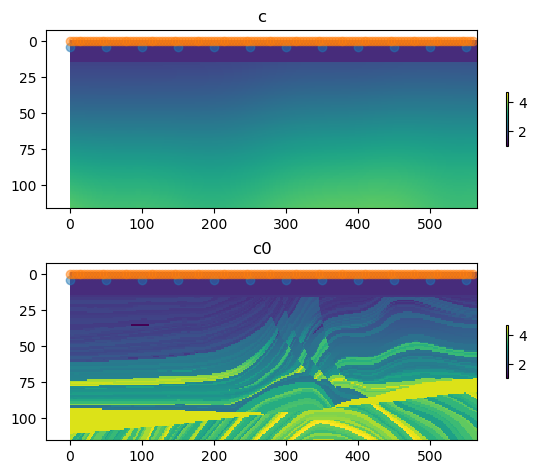

In [15]:
@eval @everywhere begin
    @load "marmousi_vp30.jld2"
    Nx, Ny = size(vel)
    h = 0.03;
    x = range(0,step=h,length=Nx)
    y = range(0,step=h,length=Ny)

    Fs = 600;
    dt = 1/Fs
    Nt = 3000;
    t = range(0, length=Nt, step=dt)
    t0 = range(0, length=4000, step=dt)

    source = source_ricker(5, 0.15, t0)
    responsetype = Highpass(3; fs=Fs)
    designmethod = FIRWindow(hanning(1024-1))
    ss = filt(digitalfilter(responsetype, designmethod), -source);
    source = ss[412:412+Nt-1]
    source = source./ maximum(source)
    
    source_position = zeros(12,2)
    for i = 1:12
        source_position[i,:] = [5 50*(i-1)+1]
    end
    source = repeat(source, 1, 12)

    receiver_position = zeros(141,2)
    for i = 1:141
        receiver_position[i,:] = [1, (i-1)*4+1]
    end

    c0 = vel
    rho0 = ones(Nx, Ny)
    
    c = copy(vel)
    c[16:end,:] = imfilter(c0[16:end,:], Kernel.gaussian(40));
    rho = ones(Nx, Ny);
end
mi = minimum(c0)
ma = maximum(c0)
figure
subplot(211)
imshow(c, aspect=2); colorbar(shrink=0.3); title("c"); clim(mi,ma)
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(212)
imshow(c0, aspect=2); colorbar(shrink=0.3); title("c0"); clim(mi,ma)
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
tight_layout()

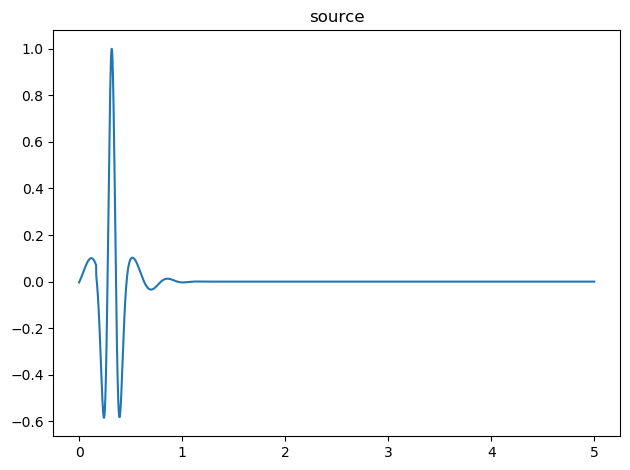

In [4]:
plot(t,source[:,1]); title("source"); tight_layout()

In [5]:
save_ratio = 30;
pml_len = 30;
pml_coef = 100;

dt * maximum(vel) / h

0.26111110051472985

In [6]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef, save_ratio=save_ratio);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef, save_ratio=save_ratio);


445.951739 seconds (8.86 M allocations: 437.913 MiB, 0.25% gc time)
424.384111 seconds (32.28 k allocations: 881.078 KiB)


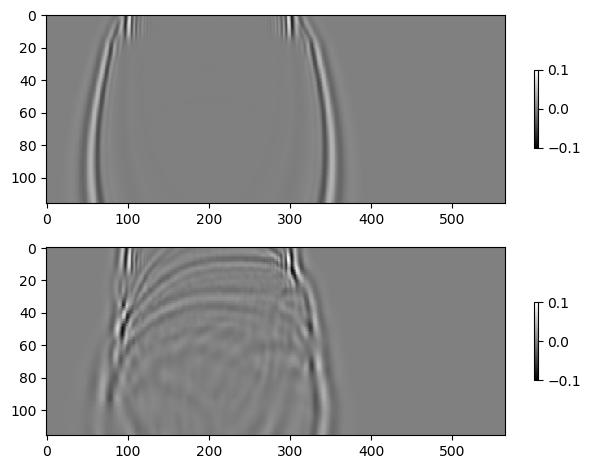

In [8]:
figure;
time_ind = 50
subplot(211); imshow(u[:,:,time_ind,5],cmap=ColorMap("gray"), aspect=2); 
colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(212); imshow(u0[:,:,time_ind,5],cmap=ColorMap("gray"), aspect=2); 
colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

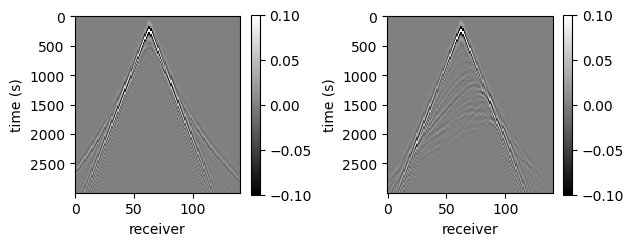

In [11]:
figure;
subplot(121); imshow(data[:,:,6],cmap=ColorMap("gray"), aspect=0.05); colorbar(shrink=0.4); clim([-0.1,0.1])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,6],cmap=ColorMap("gray"), aspect=0.05); colorbar(shrink=0.4); clim([-0.1,0.1])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [12]:
@save "marmousi_data/marmousi_mode.jld2" c c0 rho Nx Ny Nt h t dt source source_position receiver_position save_ratio pml_len pml_coef


In [13]:
@save "marmousi_data/marmousi_data.jld2" data data0